In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [36]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.beta import Beta
import numpy as np
import pandas as pd
import random
import pickle
import time
import base64
from sklearn.metrics import average_precision_score, recall_score, classification_report, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import re

In [48]:
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
SEED = 42
torch.manual_seed(SEED)
LOAD_MODEL_WEIGHTS = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/average-bert-frozen/model.pth')

MODEL_SIZE = 3
EMB_SIZE = 'base' # 'base' 768 embeddings or 'large' 1024 embeddings

In [ ]:
test_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/test_dataset.csv')

In [49]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cpu


In [50]:
EMBEDDINGS = 'hubert_embeddings'

def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name', 'classification', EMBEDDINGS, 'bert_embeddings']

test_df = pd.read_csv(test_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor, 'bert_embeddings': to_tensor})

In [51]:
def print_dataset_balance(df):
    classification_counts = df['classification'].value_counts().reset_index()
    # Rename the columns for clarity
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

In [52]:
print_dataset_balance(test_df)

# Apply means across hubert embeddings
test_df[EMBEDDINGS] = test_df[EMBEDDINGS].apply(lambda x: torch.mean(x, dim=0))

   classification  count  percentage
0               1    284        74.3
1               0     98        25.7


In [53]:
class EmbeddingsDataset(Dataset):
    def __init__(self, bert_embeddings, audio_embeddings, file_names, labels):
        self.bert_embeddings = bert_embeddings
        self.audio_embeddings = audio_embeddings
        self.file_names = file_names
        self.labels = labels

    def __len__(self):
        return len(self.audio_embeddings)

    def __getitem__(self, idx):
        bert_embedding = self.bert_embeddings[idx]
        audio_embedding = self.audio_embeddings[idx]
        label = self.labels[idx]
        file_name = self.file_names[idx]
        return bert_embedding, audio_embedding, file_name, label

bert_test_data = test_df['bert_embeddings']
audio_test_data = test_df[EMBEDDINGS]
test_labels = test_df['classification']
test_file_names = test_df['audio_file_name']

test_dataset = EmbeddingsDataset(bert_test_data, audio_test_data, test_file_names, test_labels)

In [54]:
BATCH_SIZE = 1 # to allow for analysis of results

# Change below for data augmentation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [55]:
if MODEL_SIZE == 1:
  hidden_layers = [256]
elif MODEL_SIZE == 2:
  hidden_layers = [512,256]
elif MODEL_SIZE == 3:
  hidden_layers = [768, 512, 256]
elif MODEL_SIZE == 4:
  hidden_layers = [1024, 768, 512, 256]

In [56]:
class AudioModel(nn.Module):
    def __init__(self, audio_embedding_dim=768, hidden_layers=[], dropout_rate=0.5):
        super(AudioModel, self).__init__()

        layers = []
        prev_dim = audio_embedding_dim
        for dim in hidden_layers:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim

        self.model = nn.Sequential(*layers)

    def forward(self, audio_embedding):
        return self.model(audio_embedding)

In [57]:
class CustomModel(nn.Module):
  def __init__(self, bert_embedding_dim=768, hubert_embedding_dim=768 if EMB_SIZE == 'base' else 1024, hidden_dim1=256, hidden_dim2=256, bert_hidden_dim=16, output_dim=1, dropout_rate=0.4):
      super(CustomModel, self).__init__()
      self.bert_layer1 = nn.Linear(bert_embedding_dim, bert_hidden_dim)
      self.dropout1 = nn.Dropout(dropout_rate)
      self.bert_layer2 = nn.Linear(bert_hidden_dim, bert_hidden_dim)
      self.dropout2 = nn.Dropout(dropout_rate)

      self.audio_model = AudioModel(audio_embedding_dim=hubert_embedding_dim, hidden_layers=hidden_layers, dropout_rate=0)


      self.fc1 = nn.Linear(hidden_layers[-1] + bert_hidden_dim, hidden_dim1)
      self.dropout5 = nn.Dropout(dropout_rate)
      self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
      self.dropout6 = nn.Dropout(dropout_rate)
      self.output_layer = nn.Linear(hidden_dim2, output_dim)

  def forward(self, bert_embedding, hubert_embedding):
      bert_out = F.relu(self.bert_layer1(bert_embedding))
      bert_out = self.dropout1(bert_out)
      bert_out = F.relu(self.bert_layer2(bert_out))
      bert_out = self.dropout2(bert_out)

      # Use the audio_model to process hubert_embedding
      hubert_out = self.audio_model(hubert_embedding)

      concatenated = torch.cat((bert_out, hubert_out), dim=1)

      fc_out = F.relu(self.fc1(concatenated))
      fc_out = self.dropout5(fc_out)
      fc_out = F.relu(self.fc2(fc_out))
      fc_out = self.dropout6(fc_out)

      output = self.output_layer(fc_out)
      return output

In [58]:
# Load the trained model
model = CustomModel().to(device)
model.load_state_dict(torch.load(LOAD_MODEL_WEIGHTS))
print('Loaded model in')
model.eval()  # set the model to evaluation mode

Loaded model in


CustomModel(
  (bert_layer1): Linear(in_features=768, out_features=16, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (bert_layer2): Linear(in_features=16, out_features=16, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (audio_model): AudioModel(
    (model): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=768, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
    )
  )
  (fc1): Linear(in_features=272, out_features=256, bias=True)
  (dropout5): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout6): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [59]:
TRUE_THRESHOLD = 0.5

y_name = []
y_true = []
y_score = []
y_assigned = []
latencies = []

def test(model, iterator):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for bert_embeddings, audio_embeddings, file_names, labels in iterator:
            start_time = time.time()
            output = model(bert_embeddings, audio_embeddings).squeeze(1)
            pred = torch.sigmoid(output)
            rounded_pred = torch.where(pred >= TRUE_THRESHOLD, torch.tensor(1, device=pred.device), torch.tensor(0, device=pred.device))
            end_time = time.time()

            latency = end_time - start_time
            latencies.append(latency)

            y_true.append(float(labels[0]))
            y_score.append(float(pred[0]))
            y_assigned.append(float(rounded_pred[0]))
            y_name.append(file_names[0])

test(model, test_loader)

In [60]:
print(classification_report(y_true, y_assigned, target_names=['non-interruption', 'interruption']))
# Average model

                  precision    recall  f1-score   support

non-interruption       0.44      0.39      0.41        98
    interruption       0.80      0.83      0.81       284

        accuracy                           0.72       382
       macro avg       0.62      0.61      0.61       382
    weighted avg       0.71      0.72      0.71       382



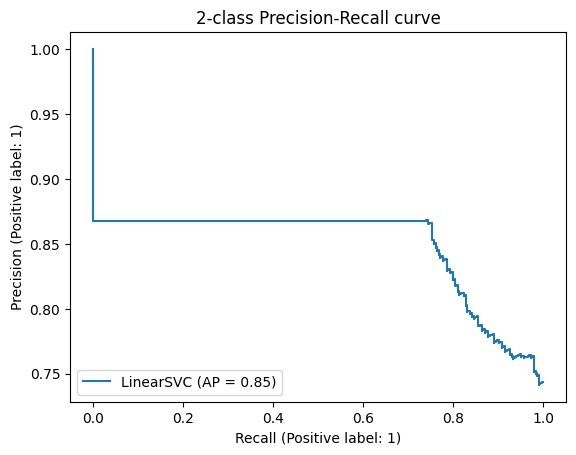

In [61]:
display = PrecisionRecallDisplay.from_predictions(
    y_true, y_score, name="LinearSVC"
)

_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [62]:
mean_latency = (sum(latencies) / len(latencies)) * 1000
print(f"Mean Latency: {mean_latency:.3f} milliseconds")

Mean Latency: 0.718 milliseconds
